In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import numpy as np
import glob
import matplotlib.pyplot as plt
from keras.models import load_model
import ntpath
from sklearn.metrics import confusion_matrix

In [8]:
from tensorflow.keras.applications import InceptionV3, MobileNetV2

In [3]:
len(MobileNetV2(weights='imagenet',input_shape=(224, 224, 3), include_top=False).layers)

9406464/9406464 [==============================] - 0s 0us/step


154

In [12]:
MobileNetV2(weights='imagenet',input_shape=(224, 224, 3), include_top=True).summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
InceptionV3(weights='imagenet',input_shape=(299, 299, 3), include_top=True).summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

## Load images

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # 299 for Inception
batch_size = 120
EPOCHS=10
train_path = 'imgs/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
test_path = 'imgs/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'
# train_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
# valid_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [4]:
# base_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
# for layer in base_model.layers:
#     layer.trainable = True

In [6]:
folders = glob.glob('imgs/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/*')
print(len(folders))

38


In [14]:
trainable = True
model_name="MobileNetV2_" + 'all_layers' if trainable else 'last_layer'
base_model = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
base_model.trainable = trainable
for layer in base_model.layers:
    layer.trainable = trainable
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(rate=0.1),
#     Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.1),
    Dense(len(folders), activation='softmax')
])


#model.summary()

In [15]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset='training')

val_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset='validation')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [18]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:

# checkpoint = ModelCheckpoint(file_path, monitor='acc', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(model_name+'.hdf5', save_weights_only=False)

early = EarlyStopping(monitor="acc", mode="max", patience=5,min_delta=0.001)

callbacks_list = [checkpoint, early, PlotLearning()] #early

history = model.fit(
  training_set,
  validation_data=val_set,
  epochs=EPOCHS,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
  callbacks=callbacks_list
)

Epoch 1/10
128/469 [=======>......................] - ETA: 5:18 - loss: 0.3053 - accuracy: 0.9075

In [ ]:
model.evaluate(test_set)

In [16]:
model.save(model_name+'.h5')

In [17]:
import pandas as pd

In [18]:
pd.DataFrame(history.history).to_csv(model_names+'.csv')

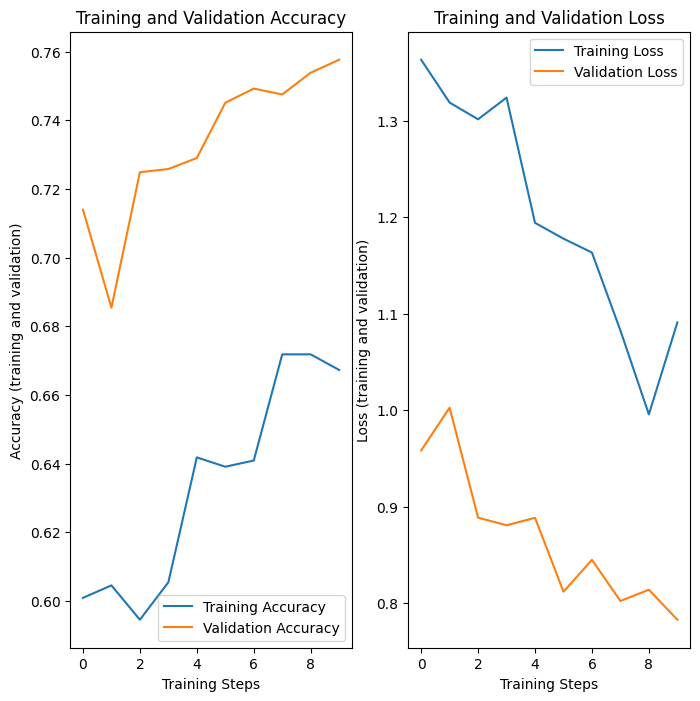

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()